# Arytmetyka i algebra dla kryptografii

In [1]:
import math
import random
import matplotlib.pyplot as plt
from time import time, localtime, strftime
# import numpy, because it was taking forever tallying up false negatives without it for some reason, idk
import numpy as np
# decimal needed to print large numbers in scientific notation
import decimal
# multiprocessing
from multiprocessing import Pool, Process

In [2]:
CORE_COUNT = 12

## Testowanie pierwszości

Głównym tematem dzisiejszych laboratoriów będą **testy pierwszości** (primality tests), tj. algorytmy sprawdzania, czy zadana liczba jest liczbą pierwszą. Jakkolwiek istnieją asymptotycznie wydajne *deterministyczne* algorytmy rozwiązujące ten problem, w praktyce są one znacznie wolniejsze i bardziej skomplikowane od algorytmów *probabilistycznych*, na których się skupimy.

Jako referencyjny test pierwszości wykorzystamy prosty algorytm sprawdzający po kolei, czy liczby naturalne z zakresu $2,...,\lfloor\sqrt{n}\rfloor$ są dzielnikami $n$.

In [3]:
def prime_naive(n):
    if n < 2:
        return False

    m = math.isqrt(n)
    for i in range(2, m + 1):
        if n % i == 0:
            return False

    return True

By przyspieszyć nieco obliczenia w pozostałych ćwiczeniach, możemy zapamiętać wyniki dla pewnego początkowego zakresu liczb.

In [4]:
SIZE = 1000001
IS_PRIME = [prime_naive(n) for n in range(SIZE)]
PRIMES = [n for n in range(SIZE) if IS_PRIME[n]]

In [5]:
def prime_ref(n):
    """
    Referencyjny test pierwszości, z którym porównywać będziemy inne metody.
    """
    if n < SIZE:
        return IS_PRIME[n]
    else:
        return prime_naive(n)

### Test Fermata

Małe twierdzenie Fermata mówi, że jeśli $p$ jest liczbą pierwszą i $0 < a < p$, to $a^{p-1} \equiv 1 \pmod p$. Fakt ten stanowi podstawę *testu pierwszości Fermata*. W teście tym by sprawdzić, czy dane $n$ jest liczbą pierwszą, losujemy $0 < a < p$ i sprawdzamy, czy $a^{n-1} \equiv 1 \pmod n$. Jeśli nie, możemy z pewnością stwierdzić, że $n$ nie jest liczbą pierwszą. Jeśli tak, to $n$ może być liczbą pierwszą (ale nie musi).

Test Fermata nie daje nam pewności, że liczba, która go pomyślnie przeszła jest liczbą pierwszą. By zwiększyć wiarygodność wyniku pozytywnego, możemy wykonać więcej niż jedną iterację, tzn. wylosować kilka wartości $a$. Jeśli test nie przejdzie dla którejkolwiek z nich, $n$ nie jest liczbą pierwszą.

#### Zadanie 1

1. Zaimplementuj test Fermata. Do obliczania $a^k \pmod N$ należy wykorzystać wbudowaną funkcję `pow`, np. `pow(a, k, mod=N)`
2. Przeanalizuj wyniki testu Fermata z jedną iteracją dla wszystkich liczb naturalnych z zakresu $\{1,\ldots,10^6\}$. Ile jest fałszywych wyników pozytywnych, tj. liczb złożonych, dla których test się powiódł? Czy sa jakieś fałszywe wyniki negatywne, tj. liczby pierwsze, dla których test się nie powiódł?
3. Ile iteracji potrzeba, by mieć rozsądne szanse na zero niepoprawnych wyników w teście z punktu 2?
4. Narysuj wykres przedstawiający ilość błędnie sklasyfikowanych liczb w teście z punktu 2 w zależności od liczby iteracji testu Fermata. Użyj skali logarytmicznej dla osi pionowej.

#### Rozwiązanie

In [6]:
MAX_ITERS = 50

In [7]:
def fermat_test(n, iters=1):
    if n < 2: return False
    for _ in range(iters):
        a = random.randint(1, n-1)
        if pow(a, n-1, mod=n) != 1:
            return False
    return True

class Fermat_test_parallel(object):
    def __init__(self, iters):
        self.iters = iters
    def __call__(self, num):
        return fermat_test(num, self.iters)

fermat_test_results = {}
for iters in range(1, MAX_ITERS+1):
    t0 = time()
    with Pool(CORE_COUNT) as p:
        fermat_test_results[iters] = p.map(Fermat_test_parallel(iters), [i for i in range(int(1e6+1))])
    t1 = time()
    print(f"Finished testing {iters} iters in {t1-t0}s")

Finished testing 1 iters in 0.33467817306518555s
Finished testing 2 iters in 0.3664968013763428s
Finished testing 3 iters in 0.3706023693084717s
Finished testing 4 iters in 0.37763190269470215s
Finished testing 5 iters in 0.40346479415893555s
Finished testing 6 iters in 0.41851091384887695s
Finished testing 7 iters in 0.4269521236419678s
Finished testing 8 iters in 0.44842028617858887s
Finished testing 9 iters in 0.45956873893737793s
Finished testing 10 iters in 0.4800426959991455s
Finished testing 11 iters in 0.48966240882873535s
Finished testing 12 iters in 0.5166847705841064s
Finished testing 13 iters in 0.5216493606567383s
Finished testing 14 iters in 0.5406818389892578s
Finished testing 15 iters in 0.5621426105499268s
Finished testing 16 iters in 0.5976417064666748s
Finished testing 17 iters in 0.6136703491210938s
Finished testing 18 iters in 0.6419079303741455s
Finished testing 19 iters in 0.661541223526001s
Finished testing 20 iters in 0.6749818325042725s
Finished testing 21 ite

In [8]:
def FP_count(classifications):
    return np.sum(np.where(classifications[classifications] == np.array(IS_PRIME)[classifications], 0, 1))

def FN_count(classifications):
    return np.sum(np.where(classifications[~classifications] == np.array(IS_PRIME)[~classifications], 0, 1))

print(f"FP count (1 iter): {FP_count(np.array(fermat_test_results[1]))}")
print(f"FN count (1 iter): {FN_count(np.array(fermat_test_results[1]))}")

FP count (1 iter): 471
FN count (1 iter): 0


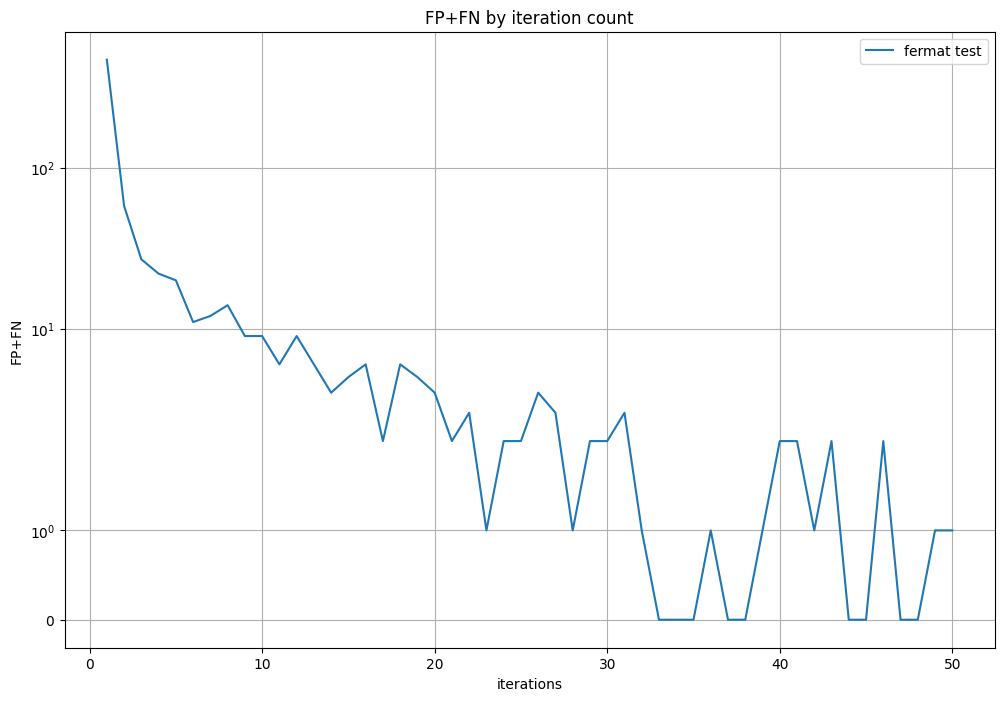

In [9]:
# set figsize
plt.figure(figsize = (12,8))
# plot results
plt.plot(
    np.arange(1, MAX_ITERS+1, 1),
    [np.sum(np.array(fermat_test_results[i]) != np.array(IS_PRIME)) for i in range(1, MAX_ITERS+1)],
    label="fermat test"
)
# set title and axes names
plt.title("FP+FN by iteration count")
plt.xlabel("iterations")
plt.ylabel("FP+FN")
# set both axes scales
plt.yscale("symlog")
# show plot with grid and legend
plt.grid()
plt.legend()
plt.show()

### Test Millera-Rabina

W teście Millera-Rabina poza małym twierdzeniem Fermata wykorzystujemy również inną własność liczb pierwszych: jeśli $n$ jest liczbą pierwszą, to $\mathbb{Z}/n\mathbb{Z}$ jest ciałem, a więc wielomiany stopnia $q$ mają w nim co najwyżej $q$ pierwiastków. W szczególności, jeśli $n$ jest liczbą pierwszą $\neq 2$, równanie $x^2 \equiv 1 \pmod n$ ma dokładnie dwa rozwiązania: $1$ oraz $-1 \equiv n - 1 \pmod n$.

Niech $n - 1 = 2^s d$, $d$ nieparzyste. Z małego twierdzenia Fermata wiemy, że dla $0 < a < n$ zachodzi $a^{2^s d} = a^{n-1} \equiv 1 \pmod n$. Jako, że $a^{2^s d} = \left(a^{2^{s-1}d}\right)^2$, to $a^{2^{s-1}d}$ jest jednym z rozwiązań równania $x^2 \equiv 1 \pmod n$, a zatem są dwie możliwości:

- $a^{2^{s-1}d} \equiv -1 \pmod n$, albo
- $a^{2^{s-1}d} \equiv 1 \pmod n$

Aplikując powyższe rozumowanie do przypadku $a^{2^{s-1}d} \equiv 1 \pmod n$, widzimy że $a^{2^{s-2}d} \equiv \pm 1 \pmod n$ i tak dalej aż do $a^d \equiv \pm 1 \pmod n$. Stąd, albo $a^d \equiv 1 \pmod n$, albo któreś z $a^d, a^{2d}, a^{4d}, \ldots, a^{2^{s-1}d}$ jest równe $-1 \pmod n$.

#### Algorytm

Na podstawie tej własności liczby pierwszej możemy zbudować następujący algorytm testujący pierwszość:

1. znajdź $s$, $d$ takie, że $n -1 = 2^s d$, $d$ nieparzyste
2. powtórz $k$ razy:
    - wylosuj $2 \leq a \leq n - 2$
    - $x \gets a^d \pmod n$
    - jeśli $x \equiv 1 \pmod n$, zakończ iterację (2)
    - powtórz $s$ razy:
        - jeśli $x \equiv -1 \pmod n$, zakończ iterację (2)
        - $x \gets x^2 \pmod n$
    - zwróć "liczba złożona"
3. żaden z testów nie wykrył złożoności, zwróć "liczba pierwsza"

#### Zadanie 2

1. Zaimplementuj test Millera-Rabina.
2. Przeprowadź dla testu Millera-Rabina analizę analogiczną do tej z Zadania 1 (punkty 2-4). Porównaj wyniki obu metod.

#### Rozwiązanie

In [10]:
def miller_rabin_test(n, iters=1):
    if n < 2: return False
    if n == 2 or n == 3: return True
    s = 0
    while (n-1)%(2**s) == 0:
        s += 1
    s -= 1
    d = (n-1)//(2**s)

    for _ in range(iters):
        a = random.randint(2, n-2)
        x = pow(a, d, mod=n)
        if x % n == 1:
            continue
        flag = True
        for _ in range(s):
            if x % n == n-1:
                flag = False
                break
            x = pow(x, 2, mod=n)
        if flag:
            return False
    return True

class Miller_rabin_test_parallel(object):
    def __init__(self, iters):
        self.iters = iters
    def __call__(self, num):
        return miller_rabin_test(num, self.iters)

miller_rabin_test_results = {}
for iters in range(1, MAX_ITERS+1):
    t0 = time()
    with Pool(CORE_COUNT) as p:
        miller_rabin_test_results[iters] = p.map(Miller_rabin_test_parallel(iters), [i for i in range(int(1e6+1))])
    t1 = time()
    print(f"Finished testing {iters} iters in {t1-t0}s")

Finished testing 1 iters in 0.46006178855895996s
Finished testing 2 iters in 0.4763624668121338s
Finished testing 3 iters in 0.5019958019256592s
Finished testing 4 iters in 0.5197656154632568s
Finished testing 5 iters in 0.5334994792938232s
Finished testing 6 iters in 0.567863941192627s
Finished testing 7 iters in 0.6030440330505371s
Finished testing 8 iters in 0.6070539951324463s
Finished testing 9 iters in 0.6201188564300537s
Finished testing 10 iters in 0.6483297348022461s
Finished testing 11 iters in 0.6664798259735107s
Finished testing 12 iters in 0.7100064754486084s
Finished testing 13 iters in 0.725292444229126s
Finished testing 14 iters in 0.7332298755645752s
Finished testing 15 iters in 0.763507604598999s
Finished testing 16 iters in 0.7798151969909668s
Finished testing 17 iters in 0.8039255142211914s
Finished testing 18 iters in 0.8346850872039795s
Finished testing 19 iters in 0.8470163345336914s
Finished testing 20 iters in 0.8796875476837158s
Finished testing 21 iters in 0.

In [11]:
print(f"Fermat - FP count (1 iter): {FP_count(np.array(fermat_test_results[1]))}")
print(f"Fermat - FN count (1 iter): {FN_count(np.array(fermat_test_results[1]))}")
print(f"Miller-Rabin - FP count (1 iter): {FP_count(np.array(miller_rabin_test_results[1]))}")
print(f"Miller-Rabin - FN count (1 iter): {FN_count(np.array(miller_rabin_test_results[1]))}")

Fermat - FP count (1 iter): 471
Fermat - FN count (1 iter): 0
Miller-Rabin - FP count (1 iter): 89
Miller-Rabin - FN count (1 iter): 0


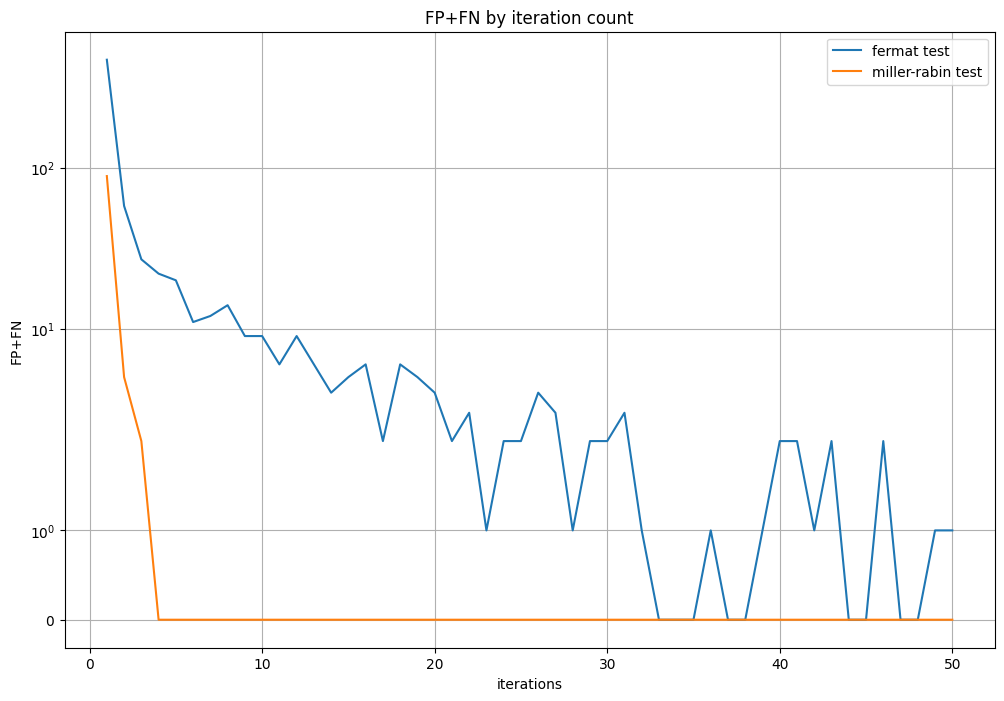

In [12]:
# set figsize
plt.figure(figsize = (12,8))
# plot results
plt.plot(
    np.arange(1, MAX_ITERS+1, 1),
    [np.sum(np.array(fermat_test_results[i]) != np.array(IS_PRIME)) for i in range(1, MAX_ITERS+1)],
    label="fermat test"
)
plt.plot(
    np.arange(1, MAX_ITERS+1, 1),
    [np.sum(np.array(miller_rabin_test_results[i]) != np.array(IS_PRIME)) for i in range(1, MAX_ITERS+1)],
    label="miller-rabin test"
)
# set title and axes names
plt.title("FP+FN by iteration count")
plt.xlabel("iterations")
plt.ylabel("FP+FN")
# set both axes scales
plt.yscale("symlog")
# show plot with grid and legend
plt.grid()
plt.legend()
plt.show()

Miller-Rabin wymaga dużo mniej iteracji, by sprawdzić z bliskim do 100% prawdopodobieństwem czy dana liczba jest liczbą pierwszą. Potrzebuje tylko kilku iteracji, by osiągnąć wartości 0, gdy test Fermata dopiero osiąga wartości 0 po ponad 30 iteracjach i nie osąga ich konsekwentnie. Natomiast każda iteracja testu Millera-Rabina wymaga wielu więcej operacji niż w teście Fermata - szczególnie dla większych liczb.

## Generowanie liczb pierwszych

### Duże liczby pierwsze dla kryptografii

W swojej książce "Applied Cryptography" Bruce Schneier proponuje następujący algorytm generowania $n$-bitowych liczb pierwszych:

1. Wygeneruj losową liczbę $n$-bitową
2. Ustaw pierwszy i ostatni bit na $1$ (by zapewnić że jest duża i nieparzysta)
3. Sprawdź, czy wygenerowana liczba jest podzielna przez małe liczby pierwsze, np. wszystkie mniejsze niż $2000$
4. Przeprowadź dla wygenerowanej liczby test Millera-Rabina z $5$ iteracjami
5. Jeśli wygenerowana liczba nie przeszła któregoś z testów (3) i (4), wróć do (1)

#### Zadanie 3

1. Zaimplementuj opisany powyżej schemat generacji liczb pierwszych. Do generacji losowej liczby $k$-bitowej można wykorzystać funkcję `getrandbits` z modułu `random`.
2. Wygeneruj przy jego pomocy liczbę pierwszą o rozmiarze 2048 bitów

#### Rozwiązanie

In [13]:
def generate_big_prime(n):
    while True:
        # random number from 1 to 0b1111111...1 (n times)
        num = random.randint(1, (1 << n)-1)
        # set first and last bit to 1
        num = num | ((1 << n-1) + 1)
        # check divisibility for primes < 2000
        flag = False
        for p in PRIMES:
            if p >= 2000: break
            if num % p == 0:
                flag = True
                break
        if flag:
            continue
        # if miller-rabin passed - assume number is prime
        if miller_rabin_test(num, iters=5):
            break
    return num

print(f"{decimal.Decimal(generate_big_prime(2048)):.5e}")

2.18222e+616


### Jeszcze większe liczby pierwsze dla przyjemności

Największa znana obecnie ludzkości liczba pierwsza to $2^{136279841} - 1$, posiadająca ponad 40 milionów cyfr dziesiętnych. Podobnie jak większość największych znanych liczb pierwszych, jest ona **liczbą Mersenne'a**, tj. ma postać
$$
M_n = 2^n - 1
$$
dla pewnego $n$. Nie wszystkie takie liczby są liczbami pierwszymi - jeśli $M_n$ jest liczbą pierwszą, to $n$ też musi być liczbą pierwszą, ale nie jest to warunek wystarczający - np. $M_{11} = 2047 = 23 \times 89$. Dla liczb Mersenne'a istnieją niemniej specjalne metody testowania pierwszości znacznie bardziej wydajne niż testy pierwszości ogólnego przeznaczenia. Najbardziej wydajną znaną metodą jest **test Lucasa-Lehmera**.

Test Lucasa-Lehmera działa następująco: dla zadanej nieparzystej liczby pierwszej $p$ konstruujemy rekurencyjnie ciąg $S_k$ tak, że

- $S_0 = 4$
- $S_k = S_{k-1}^2 - 2$

Wówczas $M_p = 2^p - 1$ jest liczbą pierwszą wtedy i tylko wtedy, gdy $S_{p-2} \equiv 0 \pmod {M_p}$

#### Zadanie 4

1. Zaimplementuj test Lucasa-Lehmera
2. Sprawdź, czy $M_3$, $M_5$, $M_{17}$, $M_{23}$, $M_{41}$, $M_{61}$, $M_{109}$, $M_{127}$, $M_{2459}$, $M_{3217}$ są liczbami pierwszymi
3. Porównaj czas działania testu Lucasa-Lehmera do czasu działania pojedynczej iteracji testu Millera-Rabina dla $M_{23209}$
4. (**dodatkowe**) Spróbuj wyliczyć jak największą liczbę pierwszą w czasie dostępnym na laboratorium. *Uwaga*: algorytm można przyspieszyć zamieniając dzielenie modulo $M_p$ na operacje binarne korzystając z tożsamości $k \equiv (k \mod 2^p) + \lfloor k / 2^p \rfloor$ - szczegóły [na Wikipedii](https://en.wikipedia.org/wiki/Lucas%E2%80%93Lehmer_primality_test)

In [14]:
TO_TEST = [3, 5, 17, 23, 41, 61, 109, 127, 2459, 3217]

#### Rozwiązanie

In [15]:
def lucas_lehmer_test(p):
    m = 2**p - 1
    s = 4
    for _ in range(p-2):
        s = (s*s - 2) % m
    return s == 0

def lucas_lehmer_test_modified(p):
    m = 2**p - 1
    s = 4
    for _ in range(p-2):
        s = s*s - 2
        while s > m:
            s = (s & m) + (s >> p)
        if s == m:
            s = 0
    return s == 0

# test given ms
for m in TO_TEST:
    t0 = time()
    result = lucas_lehmer_test(m)
    t1 = time()
    print(f"Tested M_{m} in {t1-t0}s - {result}")

# compare times
p = 23209
print(f"\nTimes for M_{p}:")
t0 = time()
result = miller_rabin_test(2**p - 1)
t1 = time()
print(f"Miller-Rabin (1 iter) - {t1-t0}s ({result})")
t0 = time()
result = lucas_lehmer_test(p)
t1 = time()
print(f"Lucas-Lehmer - {t1-t0}s ({result})")
t0 = time()
result = lucas_lehmer_test_modified(p)
t1 = time()
print(f"Lucas-Lehmer modified - {t1-t0}s ({result})")

Tested M_3 in 2.384185791015625e-06s - True
Tested M_5 in 2.1457672119140625e-06s - True
Tested M_17 in 2.86102294921875e-06s - True
Tested M_23 in 3.0994415283203125e-06s - False
Tested M_41 in 8.106231689453125e-06s - False
Tested M_61 in 1.2159347534179688e-05s - True
Tested M_109 in 2.2411346435546875e-05s - False
Tested M_127 in 3.0517578125e-05s - True
Tested M_2459 in 0.025139331817626953s - False
Tested M_3217 in 0.05464005470275879s - True

Times for M_23209:
Miller-Rabin (1 iter) - 19.330426454544067s (True)
Lucas-Lehmer - 15.956300735473633s (True)
Lucas-Lehmer modified - 2.388042449951172s (True)


In [16]:
# LAB_TIME = 90 mins
MAX_TIME_M = 90
MAX_TIME_S = MAX_TIME_M * 60

def print_found(pid, t0, p):
    t1 = time()
    elapsed = (t1-t0)/60
    Mp = decimal.Decimal((1<<p) - 1)
    print(f"Process {pid:02}: {strftime("%H:%M:%S", localtime(t1))} ({elapsed:.4f} minutes since start) - M_{p} is prime and equals {Mp:.3e}\n", end="")

def find_big_primes(process_id, t0):
    print(f"Process {process_id:02} started\n", end="")
    prime_id = process_id
    prime = PRIMES[prime_id]
    while time() - t0 < MAX_TIME_S and prime_id < len(PRIMES):
        if lucas_lehmer_test_modified(prime):
            print_found(process_id, t0, prime)
        prime_id += CORE_COUNT
        prime = PRIMES[prime_id]
    print(f"Process {process_id:02} ended\n", end="")

t0 = time()
processes = [Process(target=find_big_primes, args=(i+1,t0,)) for i in range(CORE_COUNT)]
print(f"START: {strftime("%H:%M:%S", localtime(t0))}")
for p in processes:
    p.start()
for p in processes:
    p.join()
print(f"END: {strftime("%H:%M:%S", localtime())}")

START: 15:51:14
Process 01 started
Process 01: 15:51:14 (0.0003 minutes since start) - M_3 is prime and equals 7.000e+0
Process 01: 15:51:14 (0.0004 minutes since start) - M_521 is prime and equals 6.865e+156
Process 02 started
Process 02: 15:51:14 (0.0005 minutes since start) - M_5 is prime and equals 3.100e+1
Process 03 started
Process 02: 15:51:14 (0.0005 minutes since start) - M_607 is prime and equals 5.311e+182
Process 03: 15:51:14 (0.0006 minutes since start) - M_7 is prime and equals 1.270e+2
Process 03: 15:51:14 (0.0007 minutes since start) - M_107 is prime and equals 1.623e+32
Process 04 started
Process 02: 15:51:14 (0.0007 minutes since start) - M_1279 is prime and equals 1.041e+385
Process 05 started
Process 05: 15:51:14 (0.0010 minutes since start) - M_13 is prime and equals 8.191e+3
Process 05: 15:51:14 (0.0010 minutes since start) - M_61 is prime and equals 2.306e+18
Process 06 started
Process 06: 15:51:14 (0.0011 minutes since start) - M_17 is prime and equals 1.311e+5


## Elementy odwrotne w $(\mathbb{Z}/n\mathbb{Z})^\times$

Standardowy algorytm Euklidesa pozwala nam obliczyć największy wspólny dzielnik liczb $a$, $b$. Jego działanie sprowadza się do obliczenia ciągu reszt z dzielenia:
$$
\begin{aligned}
r_0 &= a, r_1 = b \\
r_2 &= r_0 \mod r_1\\
r_3 &= r_1 \mod r_2\\
\ldots & \\
r_n &= r_{n-2} \mod r_{n-1} \\
\ldots &
\end{aligned}
$$
aż do momentu, gdy $r_n = 0$, wówczas $r_{n-1}$ to szukana wartość $d = (a, b)$. Z lematu Bézouta wiemy, że istnieją liczby całkowite $s$, $t$ takie, że $sa + tb = 1$. Rozszerzony algorytm Euklidesa pozwala nam je wyliczyć. Poza ciągiem $\{r_k\}$ obliczamy w nim również ciągi pomocnicze $\{s_k\}$, $\{t_k\}$ o własności
$$
s_k a + t_k b = r_k
$$
W każdej iteracji algorytmu mając dane wartości $s_{k-1}, t_{k-1}, r_{k-1}$ oraz $s_k, t_k, r_k$, możemy obliczyć $s_{k+1}, t_{k+1}, r_{k+1}$ w następupjący sposób. Wiemy, że $r_{k-1} = q r_k + r_{k+1}$ dla pewnego $q$, konkretnie $q = \lfloor r_{k - 1} / r_k\rfloor$. Stąd, $r_{k+1} = r_{k-1} - q r_k$. Skoro zaś
$$
r_{k-1} = s_{k-1} a + t_{k-1} b, \quad r_k = s_k a + t_k b
$$
to również
$$
\begin{aligned}
r_{k+1} &= s_{k-1} a + t_{k-1} b - q(s_k a + t_k b) \\&=
(s_{k-1} - q s_k)a + (t_{k-1} - q t_k) b
\end{aligned}
$$
a zatem możemy przyjąć $s_{k+1} = s_{k-1} - q s_k$ oraz $t_{k+1} = t_{k-1} - q t_k$. Ostatecznie mamy zatem
$$
\begin{aligned}
r_{k+1} &= r_{k-1} - q r_k \\
s_{k+1} &= s_{k-1} - q s_k \\
t_{k+1} &= t_{k-1} - q t_k \\
\end{aligned}
$$

Jeśli $(a, n) = 1$, to mając wyliczone rozszerzonym algorytmem Euklidesa liczby całkowite $s$, $t$ takie, że $sa + tn = 1$, możemy wyliczyć element odwrotny do $a$ w $\mathbb{Z} / n\mathbb{Z}$ jako $a^{-1} \equiv s \pmod n$, jako że $n$ dzieli $sa - 1 = tn$.

#### Zadanie 5

1. Zaimplementuj rozszerzony algorytm Euklidesa wyznaczający dla zadanych $a, b \in \mathbb{Z}$ wartość $(a, b)$ oraz $s, t \in \mathbb{Z}$ takie, że $sa + tb = (a, b)$.
2. Zaimplementuj funkcję znajdującą dla danego $a$ element odwrotny modulo $n$
3. Przetestuj działanie powyższej funkcji dla kilku dużych (np. $1024$ bitowych) modułów.

#### Rozwiązanie

In [17]:
# extended euclid
def extended_euclid(a, b):
    r0, r1 = a, b
    s0, s1 = 1, 0
    t0, t1 = 0, 1
    while r1 != 0:
        q = int(r0/r1)
        r0, r1 = r1, r0 - q*r1
        s0, s1 = s1, s0 - q*s1
        t0, t1 = t1, t0 - q*t1
    return r0, s0, t0

# find modulo inverse
def modulo_inverse(a, n):
    d, s, _ = extended_euclid(a, n)
    if d != 1:
        print("d != 1 - no inverse modulo")
        return None
    return s if s >= 0 else s+n

# test
TEST_COUNT = 10
BIT_COUNT = 1024
passed = 0
for i in range(TEST_COUNT):
    a = random.randint(1, (1 << BIT_COUNT-1) - 1)
    n = generate_big_prime(BIT_COUNT)
    a_inv = modulo_inverse(a, n)
    mod = (a*a_inv) % n
    passed += 1 if mod == 1 else 0
    print(f"Test {i+1}: a*a^-1 = {mod} mod n ({"ok" if mod == 1 else "bad"})")
print(f"Passed: {passed} / {TEST_COUNT}")

Test 1: a*a^-1 = 1 mod n (ok)
Test 2: a*a^-1 = 1 mod n (ok)
Test 3: a*a^-1 = 1 mod n (ok)
Test 4: a*a^-1 = 1 mod n (ok)
Test 5: a*a^-1 = 1 mod n (ok)
Test 6: a*a^-1 = 1 mod n (ok)
Test 7: a*a^-1 = 1 mod n (ok)
Test 8: a*a^-1 = 1 mod n (ok)
Test 9: a*a^-1 = 1 mod n (ok)
Test 10: a*a^-1 = 1 mod n (ok)
Passed: 10 / 10
